In [8]:
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import joblib

In [4]:
def fetchStockInfo(ticker_symbol):
    t = yf.Ticker(ticker_symbol)
    df = t.history(period="5y")
    info = t.info
    sector_name = info.get('sector', 'Unknown')
    df['Sector'] = sector_name
    
    # --- 1. CALCULATE TARGET LABEL (INTRINSIC) ---
    eps = info.get('trailingEps', 0)
    bvps = info.get('bookValue', 0)
    
    # The Graham Formula (Intrinsic Value)
    graham_val = np.sqrt(22.5 * eps * bvps) if (eps > 0 and bvps > 0) else 0
    
    # 3. THE TARGET LABEL (0: Under, 1: Fair, 2: Over)
    # Using a 10% buffer for "Fair Value"
    def get_label(price):
        if graham_val == 0: return 1
        if price < (graham_val * 0.9): return 0 # Undervalued
        elif price > (graham_val * 1.1): return 2 # Overvalued
        else: return 1 # Fairly Valued
    
    df['Target'] = df['Close'].apply(get_label)
    
    # --- 2. CALCULATE INDEPENDENT VARIABLES (FEATURES) ---
    df['PE_Ratio'] = info.get('trailingPE', 0)
    df['ROE'] = info.get('returnOnEquity', 0)
    
    # Momentum Feature (SMA Ratio)
    df['SMA_30'] = df['Close'].rolling(30).mean()
    df['SMA_90'] = df['Close'].rolling(90).mean()
    df['Momentum'] = df['SMA_30'] / df['SMA_90']
    
    # Risk Feature (Volatility)
    df['Volatility'] = df['Close'].pct_change().rolling(30).std()
    essential_cols = ['Close', 'PE_Ratio', 'ROE', 'Momentum', 'Volatility', 'Sector', 'Target']
    df = df[essential_cols].dropna()
    
    return df,graham_val

In [6]:
# 1. DEFINE THE UNIVERSE (10 per sector)
sector_map = {
    'Technology': ['AAPL', 'MSFT', 'NVDA', 'ORCL', 'ADBE', 'CRM', 'INTC', 'CSCO', 'AMD', 'IBM'],
    'Financials': ['JPM', 'BAC', 'GS', 'MS', 'WFC', 'C', 'BLK', 'PYPL', 'V', 'MA'],
    'Healthcare': ['PFE', 'JNJ', 'UNH', 'ABBV', 'MRK', 'LLY', 'AMGN', 'TMO', 'GILD', 'BMY'],
    'Discretionary': ['TSLA', 'AMZN', 'F', 'GM', 'HD', 'NKE', 'SBUX', 'MCD', 'BKNG', 'NCLH'],
    'Energy': ['XOM', 'CVX', 'SHEL', 'BP', 'TTE', 'COP', 'SLB', 'EOG', 'MPC', 'VLO'],
    'Staples': ['WMT', 'KO', 'PEP', 'COST', 'PG', 'EL', 'CL', 'MO', 'TGT', 'PM'],
    'Industrials': ['BA', 'CAT', 'GE', 'UPS', 'FDX', 'HON', 'LMT', 'MMM', 'DE', 'RTX'],
    'Utilities': ['NEE', 'DUK', 'SO', 'D', 'AEP', 'PLD', 'AMT', 'EQIX', 'CCI', 'O']
}

all_data = []

# 2. THE COLLECTOR LOOP
for sector, tickers in sector_map.items():
    print(f"\n--- Processing Sector: {sector} ---")
    for ticker in tickers:
        try:
            print(f"Fetching {ticker}")
           
            # Note: Ensure your function returns a DataFrame
            df, graham_val = fetchStockInfo(ticker)
            
            # Explicitly label the sector and ticker for the model
            df['Sector'] = sector
            df['Ticker'] = ticker
            
            all_data.append(df)
            time.sleep(0.5) # Prevents Yahoo IP block
        except Exception as e:
            print(f"Error on {ticker}: {e}")

# 3. CONSOLIDATE AND SAVE
master_df = pd.concat(all_data, ignore_index=True)
master_df.to_csv('master_training_data.csv', index=False)

print("\n" + "="*30)
print("SUCCESS: Master Dataset 'master_training_data.csv' Created.")
print(f"Total Rows: {len(master_df)}")
print("="*30)


--- Processing Sector: Technology ---
Fetching AAPL...
Fetching MSFT...
Fetching NVDA...
Fetching ORCL...
Fetching ADBE...
Fetching CRM...
Fetching INTC...
Fetching CSCO...
Fetching AMD...
Fetching IBM...

--- Processing Sector: Financials ---
Fetching JPM...
Fetching BAC...
Fetching GS...
Fetching MS...
Fetching WFC...
Fetching C...
Fetching BLK...
Fetching PYPL...
Fetching V...
Fetching MA...

--- Processing Sector: Healthcare ---
Fetching PFE...
Fetching JNJ...
Fetching UNH...
Fetching ABBV...
Fetching MRK...
Fetching LLY...
Fetching AMGN...
Fetching TMO...
Fetching GILD...
Fetching BMY...

--- Processing Sector: Discretionary ---
Fetching TSLA...
Fetching AMZN...
Fetching F...
Fetching GM...
Fetching HD...
Fetching NKE...
Fetching SBUX...
Fetching MCD...
Fetching BKNG...
Fetching NCLH...

--- Processing Sector: Energy ---
Fetching XOM...
Fetching CVX...
Fetching SHEL...
Fetching BP...
Fetching TTE...
Fetching COP...
Fetching SLB...
Fetching EOG...
Fetching MPC...
Fetching VLO...



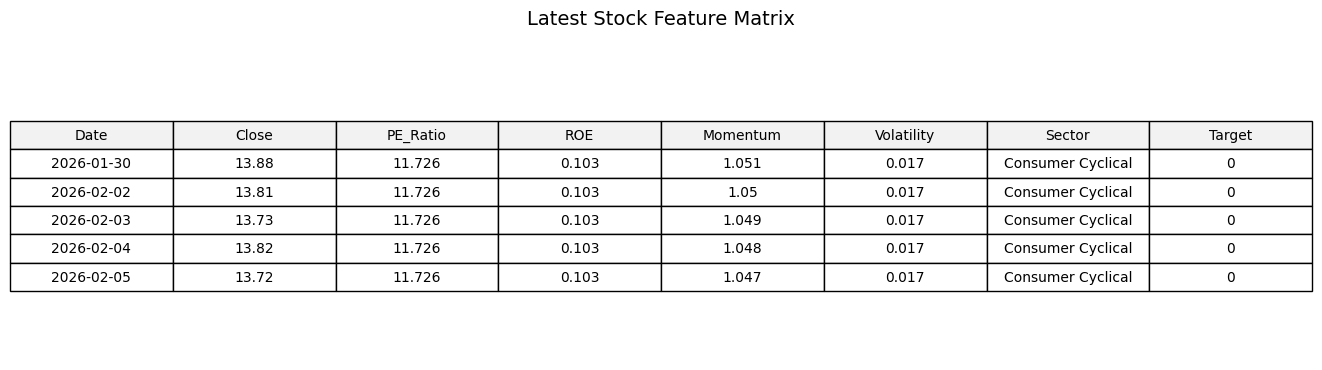

In [7]:
data, intrinsic_price = fetchStockInfo("F")
table_data = data.tail(5).copy()
table_data = table_data.round(3)




# Reset index to make 'Date' a visible column in the table
table_data = table_data.reset_index()
table_data['Date'] = table_data['Date'].dt.strftime('%Y-%m-%d')

# 2. Create the Plot
fig, ax = plt.subplots(figsize=(14, 4)) # Adjust size for your report
ax.axis('tight')
ax.axis('off')

# 3. Create the Table
table = ax.table(cellText=table_data.values, 
                 colLabels=table_data.columns, 
                 cellLoc='center', 
                 loc='center',
                 colColours=["#f2f2f2"] * len(table_data.columns)) # Light grey header

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.7) # Scale for better spacing

plt.title("Latest Stock Feature Matrix", fontsize=14, pad=20)
plt.show()

In [9]:
# 1. LOAD DATA
df = pd.read_csv('master_training_data.csv')

# 2. SECTOR ENCODING (The "One-Hot" Method)
# This turns the 'Sector' column into 8 separate columns of 0s and 1s
df_encoded = pd.get_dummies(df, columns=['Sector'])

# 3. DEFINE FEATURES (X) AND TARGET (y)
# We drop columns that aren't math features (like Ticker/Date)
X = df_encoded.drop(['Target', 'Ticker', 'Close'], axis=1, errors='ignore')
y = df_encoded['Target']

# 4. TRAIN/TEST SPLIT
# 80% to learn the rules, 20% to test if it's right
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 5. INITIALIZE AND TRAIN THE MODEL
# n_estimators=100 means we are using 100 "Decision Trees" working together
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 6. EVALUATE
y_pred = model.predict(X_test)
print("--- Model Performance ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


--- Model Performance ---
Accuracy: 0.95

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.91      0.91      2539
           1       0.92      0.89      0.90      3524
           2       0.97      0.98      0.98     12593

    accuracy                           0.95     18656
   macro avg       0.93      0.93      0.93     18656
weighted avg       0.95      0.95      0.95     18656

